## Discrete-Time Black Scholes
Welcome to your 1st assignment in Reinforcement Learning in Finance. This exercise will introduce Black-Scholes model as viewed through the lens of pricing an option as discrete-time replicating portfolio of stock and bond.

**Instructions:**
- You will be using Python 3.
- Avoid using for-loops and while-loops, unless you are explicitly told to do so.
- Do not modify the (# GRADED FUNCTION [function name]) comment in some cells. Your work would not be graded if you change this. Each cell containing that comment should only contain one function.
- After coding your function, run the cell right below it to check if your result is correct.


Let's get started!

## About iPython Notebooks ##

iPython Notebooks are interactive coding environments embedded in a webpage. You will be using iPython notebooks in this class. You only need to write code between the ### START CODE HERE ### and ### END CODE HERE ### comments. After writing your code, you can run the cell by either pressing "SHIFT"+"ENTER" or by clicking on "Run Cell" (denoted by a play symbol) in the upper bar of the notebook. 

We will often specify "(≈ X lines of code)" in the comments to tell you about how much code you need to write. It is just a rough estimate, so don't feel bad if your code is longer or shorter.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import standard_normal, seed

import scipy.stats as stats
from scipy.stats import norm

import sys

sys.path.append("..")
import grading

import datetime 
import time
import bspline
import bspline.splinelab as splinelab

In [2]:
### ONLY FOR GRADING. DO NOT EDIT ###
submissions=dict()
assignment_key="J_L65CoiEeiwfQ53m1Mlug" 
all_parts=["9jLRK","YoMns","Wc3NN","fcl3r"]
### ONLY FOR GRADING. DO NOT EDIT ###

In [3]:
COURSERA_TOKEN =  '' # the key provided to the Student under his/her email on submission page
COURSERA_EMAIL = '' # the email

In [4]:
# The Black-Scholes prices
def bs_put(t, S0, K, r, sigma, T):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = K * np.exp(-r * (T-t)) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return price

def bs_call(t, S0, K, r, sigma, T):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = S0 * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2)
    return price

def d1(S0, K, r, sigma, T):
    return (np.log(S0/K) + (r + sigma**2 / 2) * T)/(sigma * np.sqrt(T))
 
def d2(S0, K, r, sigma, T):
    return (np.log(S0 / K) + (r - sigma**2 / 2) * T) / (sigma * np.sqrt(T))
 

Simulate $N_{MC}$ stock price sample paths with $T$ steps by the classical Black-Sholes formula.

$$dS_t=\mu S_tdt+\sigma S_tdW_t\quad\quad S_{t+1}=S_te^{\left(\mu-\frac{1}{2}\sigma^2\right)\Delta t+\sigma\sqrt{\Delta t}Z}$$

where $Z$ is a standard normal random variable.

MC paths are simulated by GeneratePaths() method of DiscreteBlackScholes class.

### Part 1


Class DiscreteBlackScholes implements the above calculations with class variables to math symbols mapping of:

$$\Delta S_t=S_{t+1} - e^{-r\Delta t} S_t\space \quad t=T-1,...,0$$
 
**Instructions:**
Some portions of code in DiscreteBlackScholes have bee taken out. You are to implement the missing portions of code in DiscreteBlackScholes class.

$$\Pi_t=e^{-r\Delta t}\left[\Pi_{t+1}-u_t \Delta S_t\right]\quad t=T-1,...,0$$

- implement DiscreteBlackScholes.function_A_vec() method
$$A_{nm}^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k\right)\Phi_m\left(X_t^k\right)\left(\Delta\hat{S}_t^k\right)^2}\quad\quad$$ 

- implement DiscreteBlackScholes.function_B_vec() method
$$B_n^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k\right)\left[\hat\Pi_{t+1}^k\Delta\hat{S}_t^k+\frac{1}{2\gamma\lambda}\Delta S_t^k\right]}$$
- implement DiscreteBlackScholes.gen_paths() method using the following relation:
$$S_{t+1}=S_te^{\left(\mu-\frac{1}{2}\sigma^2\right)\Delta t+\sigma\sqrt{\Delta t}Z}$$
where $Z \sim N(0,1)$
- implement parts of DiscreteBlackScholes.roll_backward()
    - DiscreteBlackScholes.bVals corresponds to $B_t$ and is computed as $$B_t = e^{-r\Delta t}\left[B_{t+1} + (u_{t+1} - u_t)S_{t+1}\right]\quad t=T-1,...,0$$
    
DiscreteBlackScholes.opt_hedge corresponds to $\phi_t$ and is computed as 
     $$\phi_t=\mathbf A_t^{-1}\mathbf B_t$$

In [14]:
class DiscreteBlackScholes:
    """
    Class implementing discrete Black Scholes
    DiscreteBlackScholes is class for pricing and hedging under
    the real-world measure for a one-dimensional Black-Scholes setting
    """

    def __init__(self,
                 s0,
                 strike,
                 vol,
                 T,
                 r,
                 mu,
                 numSteps,
                 numPaths):
        """
        :param s0: initial price of the underlying
        :param strike: option strike
        :param vol: volatility
        :param T: time to maturity, in years
        :param r: risk-free rate,
        :param mu: real drift, asset drift
        :param numSteps: number of time steps
        :param numPaths: number of Monte Carlo paths
        """
        self.s0 = s0
        self.strike = strike
        self.vol = vol
        self.T = T
        self.r = r
        self.mu = mu
        self.numSteps = numSteps
        self.numPaths = numPaths

        self.dt = self.T / self.numSteps  # time step
        self.gamma = np.exp(-r * self.dt)  # discount factor for one time step, i.e. gamma in the QLBS paper

        self.sVals = np.zeros((self.numPaths, self.numSteps + 1), 'float')  # matrix of stock values

        # initialize half of the paths with stock price values ranging from 0.5 to 1.5 of s0
        # the other half of the paths start with s0
        half_paths = int(numPaths / 2)

        if False:
            # Grau (2010) "Applications of Least-Squares Regressions to Pricing and Hedging of Financial Derivatives"
            self.sVals[:, 0] = (np.hstack((np.linspace(0.5 * s0, 1.5 * s0, half_paths),
                                           s0 * np.ones(half_paths, 'float')))).T

        self.sVals[:, 0] = s0 * np.ones(numPaths, 'float')
        self.optionVals = np.zeros((self.numPaths, self.numSteps + 1), 'float')  # matrix of option values
        self.intrinsicVals = np.zeros((self.numPaths, self.numSteps + 1), 'float')

        self.bVals = np.zeros((self.numPaths, self.numSteps + 1), 'float')  # matrix of cash position values
        self.opt_hedge = np.zeros((self.numPaths, self.numSteps + 1),
                              'float')  # matrix of optimal hedges calculated from cross-sectional information F_t
        self.X = None
        self.data = None  # matrix of features, i.e. self.X as sum of basis functions
        self.delta_S_hat = None

        # coef = 1.0/(2 * gamma * risk_lambda)
        # override it by zero to have pure risk hedge
        self.coef = 0.

    def gen_paths(self):
        """
        A simplest path generator
        """
        np.random.seed(42)
        # Spline basis of order p on knots k

        ### START CODE HERE ### (≈ 3-4 lines of code)
        # self.sVals = your code goes here ...
        # for-loop or while loop is allowed heres
        
        Z = np.random.normal(0, 1, size=(self.numSteps + 1, self.numPaths)).T
        for t in range(0, self.numSteps):
            self.sVals[:, t + 1] = self.sVals[:, t] * np.exp((self.mu - 0.5 * self.vol**2) * self.dt + (self.vol * np.sqrt(self.dt) * Z[:, t + 1]))
        
        print(self.sVals)
        ### END CODE HERE ###

        # like in QLBS
        delta_S = self.sVals[:, 1:] - np.exp(self.r * self.dt) * self.sVals[:, :self.numSteps]
        self.delta_S_hat = np.apply_along_axis(lambda x: x - np.mean(x), axis=0, arr=delta_S)

        # state variable
        # delta_t here is due to their conventions
        self.X = - (self.mu - 0.5 * self.vol ** 2) * np.arange(self.numSteps + 1) * self.dt + np.log(self.sVals)

        X_min = np.min(np.min(self.X))
        X_max = np.max(np.max(self.X))

        print('X.shape = ', self.X.shape)
        print('X_min, X_max = ', X_min, X_max)

        p = 4  # order of spline (as-is; 3 = cubic, 4: B-spline?)
        ncolloc = 12
        tau = np.linspace(X_min, X_max, ncolloc)  # These are the sites to which we would like to interpolate

        # k is a knot vector that adds endpoints repeats as appropriate for a spline of order p
        # To get meaningful results, one should have ncolloc >= p+1
        k = splinelab.aptknt(tau, p)
        basis = bspline.Bspline(k, p)

        num_basis = ncolloc  # len(k) #
        self.data = np.zeros((self.numSteps + 1, self.numPaths, num_basis))

        print('num_basis = ', num_basis)
        print('dim self.data = ', self.data.shape)

        # fill it, expand function in finite dimensional space
        # in neural network the basis is the neural network itself
        t_0 = time.time()
        for ix in np.arange(self.numSteps + 1):
            x = self.X[:, ix]
            self.data[ix, :, :] = np.array([basis(el) for el in x])
        t_end = time.time()
        print('\nTime Cost of basis expansion:', t_end - t_0, 'seconds')

    def function_A_vec(self, t, reg_param=1e-3):
        """
        function_A_vec - compute the matrix A_{nm} from Eq. (52) (with a regularization!)
        Eq. (52) in QLBS Q-Learner in the Black-Scholes-Merton article

        Arguments:
        t - time index, a scalar, an index into time axis of data_mat
        reg_param - a scalar, regularization parameter

        Return:
        - np.array, i.e. matrix A_{nm} of dimension num_basis x num_basis
        """
        X_mat = self.data[t, :, :]
        num_basis_funcs = X_mat.shape[1]
        this_dS = self.delta_S_hat[:, t]
        hat_dS2 = (this_dS ** 2).reshape(-1, 1)
        A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_funcs)
        return A_mat

    def function_B_vec(self, t, Pi_hat):
        """
        function_B_vec - compute vector B_{n} from Eq. (52) QLBS Q-Learner in the Black-Scholes-Merton article

        Arguments:
        t - time index, a scalar, an index into time axis of delta_S_hat
        Pi_hat - pandas.DataFrame of dimension N_MC x T of portfolio values
        Return:
        B_vec - np.array() of dimension num_basis x 1
        """
        tmp = Pi_hat * self.delta_S_hat[:, t] + self.coef * (np.exp((self.mu - self.r) * self.dt)) * self.sVals[:, t]
        X_mat = self.data[t, :, :]  # matrix of dimension N_MC x num_basis

        B_vec = np.dot(X_mat.T, tmp)
        return B_vec

    def seed_intrinsic(self, strike=None, cp='P'):
        """
        initilaize option value and intrinsic value for each node
        """
        if strike is not None:
            self.strike = strike

        if cp == 'P':
            # payoff function at maturity T: max(K - S(T),0) for all paths
            self.optionVals = np.maximum(self.strike - self.sVals[:, -1], 0).copy()
            # payoff function for all paths, at all time slices
            self.intrinsicVals = np.maximum(self.strike - self.sVals, 0).copy()
        elif cp == 'C':
            # payoff function at maturity T: max(S(T) -K,0) for all paths
            self.optionVals = np.maximum(self.sVals[:, -1] - self.strike, 0).copy()
            # payoff function for all paths, at all time slices
            self.intrinsicVals = np.maximum(self.sVals - self.strike, 0).copy()
        else:
            raise Exception('Invalid parameter: %s'% cp)

        self.bVals[:, -1] = self.intrinsicVals[:, -1]

    def roll_backward(self):
        """
        Roll the price and optimal hedge back in time starting from maturity
        """

        for t in range(self.numSteps - 1, -1, -1):

            # determine the expected portfolio value at the next time node
            piNext = self.bVals[:, t+1] + self.opt_hedge[:, t+1] * self.sVals[:, t+1]
            pi_hat = piNext - np.mean(piNext)

            A_mat = self.function_A_vec(t)
            B_vec = self.function_B_vec(t, pi_hat)
            phi = np.dot(np.linalg.inv(A_mat), B_vec)
            self.opt_hedge[:, t] = np.dot(self.data[t, :, :], phi)

            ### START CODE HERE ### (≈ 1-2 lines of code)
            # implement code to update self.bVals
            # self.bVals[:,t] = your code goes here ....
            self.bVals[:,t] = np.exp(-self.r * self.dt) * (self.bVals[:, t+1] + (self.opt_hedge[:, t+1] - self.opt_hedge[:, t]) * self.sVals[:, t+1])
      

            ### END CODE HERE ###

        # calculate the initial portfolio value
        initPortfolioVal = self.bVals[:, 0] + self.opt_hedge[:, 0] * self.sVals[:, 0]

        # use only the second half of the paths generated with paths starting from S0
        optionVal = np.mean(initPortfolioVal)
        optionValVar = np.std(initPortfolioVal)
        delta = np.mean(self.opt_hedge[:, 0])

        return optionVal, delta, optionValVar

[[ 100.           98.23650359   98.6842395  ...,  111.52820537
   111.93345414  111.50088104]
 [ 100.           99.47538589  100.18466561 ...,   69.58859259
    69.36721589   68.46903615]
 [ 100.           99.57310236  100.94511135 ...,  110.66761375
   110.53260244  110.37282496]
 ..., 
 [ 100.          100.19783913  100.59050962 ...,  151.7887043   151.63565543
   152.14692905]
 [ 100.          100.07733423  101.11151453 ...,  103.08321744
   101.41095506  101.46651123]
 [ 100.           98.57422289   99.36322314 ...,   91.31429149
    91.06798685   92.50219743]]
X.shape =  (100, 253)
X_min, X_max =  4.10743882917 5.16553756345
num_basis =  12
dim self.data =  (253, 100, 12)

Time Cost of basis expansion: 7.709317445755005 seconds


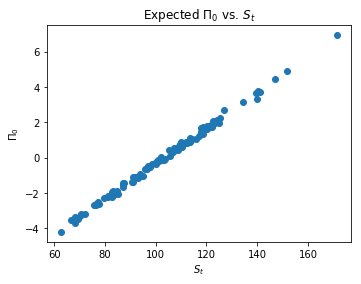

In [15]:
np.random.seed(42)
strike_k = 95
test_vol = 0.2
test_mu = 0.03
dt = 0.01
rfr = 0.05
num_paths = 100
num_periods = 252

hMC = DiscreteBlackScholes(100, strike_k, test_vol, 1., rfr, test_mu, num_periods, num_paths)
hMC.gen_paths()

t = hMC.numSteps - 1
piNext = hMC.bVals[:, t+1] + 0.1 * hMC.sVals[:, t+1]
pi_hat = piNext - np.mean(piNext)

A_mat = hMC.function_A_vec(t)
B_vec = hMC.function_B_vec(t, pi_hat)
phi = np.dot(np.linalg.inv(A_mat), B_vec)
opt_hedge = np.dot(hMC.data[t, :, :], phi)

# plot the results
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)

ax1.scatter(hMC.sVals[:,t], pi_hat)
ax1.set_title(r'Expected $\Pi_0$ vs. $S_t$')
ax1.set_xlabel(r'$S_t$')
ax1.set_ylabel(r'$\Pi_0$')

In [16]:
### GRADED PART (DO NOT EDIT) ###

part_1 = list(pi_hat)
try:
    part1 = " ".join(map(repr, part_1))
except TypeError:
    part1 = repr(part_1)
submissions[all_parts[0]]=part1
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:1],all_parts,submissions)
pi_hat
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([ 0.81274895, -3.49043554,  0.69994334,  1.61239986, -0.25153316,
       -3.19082265,  0.8848621 , -2.0380868 ,  0.45033564,  3.74872863,
       -0.6568227 ,  1.74148929,  0.94314331, -4.19716113,  1.72135256,
       -0.66188482,  6.95675041, -2.20512677, -0.14942482,  0.30067272,
        3.33419402,  0.68536713,  1.65097153,  2.69898611,  1.22528159,
        1.47188744, -2.48129898, -0.37360224,  0.81064666, -1.05269459,
        0.02476551, -1.88267258,  0.11748169, -0.9038195 ,  0.69753811,
       -0.54805029,  1.97594593, -0.44331403,  0.62134931, -1.86191032,
       -3.21226413,  2.24508097, -2.23451292, -0.13488281,  3.64364848,
       -0.11270281, -1.15582237, -3.30169455,  1.74454841, -1.10425448,
        2.10192819,  1.80570507, -1.68587001, -1.42113397, -2.70292006,
        0.79454199, -2.05396827,  3.13973887, -1.08786662,  0.42347686,
        1.32787012,  0.55924965, -3.54140814, -3.70258632,  2.14853641,
        1.11495458,  3.69639676,  0.62864736, -2.62282995, -0.05

In [17]:
# input parameters
s0 = 100.0
strike = 100.0
r = 0.05
mu = 0.07 # 0.05
vol = 0.4
T = 1.0

# Simulation Parameters
numPaths = 50000  # number of Monte Carlo trials
numSteps = 6

# create the class object
hMC = DiscreteBlackScholes(s0, strike, vol, T, r, mu, numSteps, numPaths)

# calculation
hMC.gen_paths()
hMC.seed_intrinsic()
option_val, delta, option_val_variance = hMC.roll_backward()
bs_call_value = bs_put(0, s0, K=strike, r=r, sigma=vol, T=T)
print('Option value = ', option_val)
print('Option value variance = ', option_val_variance)
print('Option delta = ', delta)  
print('BS value', bs_call_value)

[[ 100.          101.44740793  119.84140463 ...,  192.78653975  210.7076386
   167.37134738]
 [ 100.           98.79378416   81.67103247 ...,   78.75163254
   104.69106128  114.29766651]
 [ 100.          116.62110943  127.89787986 ...,   85.9631909    79.72061217
    78.03372489]
 ..., 
 [ 100.          106.73222875  103.49782882 ...,  108.30352919
    96.76512324  114.08668191]
 [ 100.           96.45073828   98.70345177 ...,   89.5899346    75.07626471
    91.91332688]
 [ 100.          101.81014094  115.21893111 ...,   68.72837469
    64.71929858   65.04500528]]
X.shape =  (50000, 7)
X_min, X_max =  2.96880459823 6.37164911461
num_basis =  12
dim self.data =  (7, 50000, 12)

Time Cost of basis expansion: 96.63819098472595 seconds
Option value =  13.1083499076
Option value variance =  5.17079676287
Option delta =  -0.356133722933
BS value 13.1458939003


In [18]:
### GRADED PART (DO NOT EDIT) ###
part2 = str(option_val)
submissions[all_parts[1]]=part2
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:2],all_parts,submissions)
option_val
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


13.10834990762385

In [19]:
strikes = np.linspace(85, 110, 6)
results = [None] * len(strikes)
bs_prices = np.zeros(len(strikes))
bs_deltas = np.zeros(len(strikes))
numPaths = 50000
hMC = DiscreteBlackScholes(s0, strike, vol, T, r, mu, numSteps, numPaths)
hMC.gen_paths()
for ix, k_strike in enumerate(strikes):
    hMC.seed_intrinsic(k_strike)
    results[ix] = hMC.roll_backward()
    bs_prices[ix] = bs_put(0, s0, K=k_strike, r=r, sigma=vol, T=T)
    bs_deltas[ix] = norm.cdf(d1(s0, K=k_strike, r=r, sigma=vol, T=T)) - 1
bs_prices

[[ 100.          101.44740793  119.84140463 ...,  192.78653975  210.7076386
   167.37134738]
 [ 100.           98.79378416   81.67103247 ...,   78.75163254
   104.69106128  114.29766651]
 [ 100.          116.62110943  127.89787986 ...,   85.9631909    79.72061217
    78.03372489]
 ..., 
 [ 100.          106.73222875  103.49782882 ...,  108.30352919
    96.76512324  114.08668191]
 [ 100.           96.45073828   98.70345177 ...,   89.5899346    75.07626471
    91.91332688]
 [ 100.          101.81014094  115.21893111 ...,   68.72837469
    64.71929858   65.04500528]]
X.shape =  (50000, 7)
X_min, X_max =  2.96880459823 6.37164911461
num_basis =  12
dim self.data =  (7, 50000, 12)

Time Cost of basis expansion: 95.9269437789917 seconds


array([  6.70326307,   8.59543726,  10.74614496,  13.1458939 ,
        15.78197485,  18.63949388])

In [20]:
mc_prices = np.array([x[0] for x in results])
mc_deltas = np.array([x[1] for x in results])
price_variances = np.array([x[-1] for x in results])
prices_diff = mc_prices - bs_prices
deltas_diff = mc_deltas - bs_deltas
# price_variances

In [21]:
### GRADED PART (DO NOT EDIT) ###

part_3 = list(prices_diff)
try:
    part3 = " ".join(map(repr, part_3))
except TypeError:
    part3 = repr(part_3)
submissions[all_parts[2]]=part3
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:3],all_parts,submissions)
prices_diff
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([-0.03641511, -0.04034139, -0.03996597, -0.03754399, -0.03240009,
       -0.02997062])

In [22]:
### GRADED PART (DO NOT EDIT) ###
part_4 = list(deltas_diff)
try:
    part4 = " ".join(map(repr, part_4))
except TypeError:
    part4= repr(part_4)
submissions[all_parts[3]]=part4
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:4],all_parts,submissions)
deltas_diff
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([ 0.01279798,  0.01416019,  0.01532701,  0.01645681,  0.01715345,
        0.01780652])